In [2]:
import os
import numpy as np
import csv
import pandas as pd
import math
import time
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
import warnings
import nltk
import yfinance as yf
from train import eval_op

def get_tech_ind(data):
    data['MA7'] = data.iloc[:,4].rolling(window=7).mean() #Close column
    data['MA20'] = data.iloc[:,4].rolling(window=20).mean() #Close Column

    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()
    #This is the difference of Closing price and Opening Price

    # Create Bollinger Bands
    data['20SD'] = data.iloc[:, 4].rolling(20).std()
    data['upper_band'] = data['MA20'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA20'] - (data['20SD'] * 2)

    # Create Exponential moving average
    data['EMA'] = data.iloc[:,4].ewm(com=0.5).mean()

    # Create LogMomentum
    data['logmomentum'] = np.log(data.iloc[:,4] - 1)

    return data

def normalize_data(df, range, target_column):

    '''
    df: dataframe object
    range: type tuple -> (lower_bound, upper_bound)
        lower_bound: int
        upper_bound: int
    target_column: type str -> should reflect closing price of stock
    '''

    target_df_series = pd.DataFrame(df[target_column])
    data = pd.DataFrame(df.iloc[:, :])

    X_scaler = MinMaxScaler(feature_range=range)
    y_scaler = MinMaxScaler(feature_range=range)
    X_scaler.fit(data)
    y_scaler.fit(target_df_series)

    X_scale_dataset = X_scaler.fit_transform(data)
    y_scale_dataset = y_scaler.fit_transform(target_df_series)
    
    dump(X_scaler, open('X_scaler.pkl', 'wb'))
    dump(y_scaler, open('y_scaler.pkl', 'wb'))

    return (X_scale_dataset,y_scale_dataset)

def batch_data(x_data,y_data, batch_size, predict_period):
    X_batched, y_batched, yc = list(), list(), list()

    for i in range(0,len(x_data),1):
        x_value = x_data[i: i + batch_size][:, :]
        y_value = y_data[i + batch_size: i + batch_size + predict_period][:, 0]
        yc_value = y_data[i: i + batch_size][:, :]
        if len(x_value) == batch_size and len(y_value) == predict_period:
            X_batched.append(x_value)
            y_batched.append(y_value)
            yc.append(yc_value)

    return np.array(X_batched), np.array(y_batched), np.array(yc)

def split_train_test(data):
    train_size = len(data) - 20
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

def predict_index(dataset, X_train, batch_size, prediction_period):

    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[batch_size: X_train.shape[0] + batch_size + prediction_period, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + batch_size:, :].index

    return train_predict_index, test_predict_index

data = pd.read_csv("Advanced Micro Device_2019.csv", encoding='utf-8', encoding_errors = 'ignore')
data = data.dropna(subset=['Date'])
data = data[['Date','Tweet']]
'''# 刪除第一個列
data.drop(columns=[data.columns[0]], inplace=True)
# 重置索引，並不保留原來的索引作為一個列
data.reset_index(drop=True, inplace=True)'''
data['Stock Name'] = "AMD"
data['Company Name'] = "Advanced Micro Devices, Inc."


nltk.download('vader_lexicon')
sent_df = data.copy()
sent_df["sentiment_score"] = ''
sent_df["Negative"] = ''
sent_df["Neutral"] = ''
sent_df["Positive"] = ''

# 情緒分析
sentiment_analyzer = SentimentIntensityAnalyzer()
for indx, row in sent_df.iterrows():
    try:
        sentence_i = unicodedata.normalize('NFKD', row['Tweet'])
        sentence_sentiment = sentiment_analyzer.polarity_scores(sentence_i)
        sent_df.at[indx, 'sentiment_score'] = sentence_sentiment['compound']
        sent_df.at[indx, 'Negative'] = sentence_sentiment['neg']
        sent_df.at[indx, 'Neutral'] = sentence_sentiment['neu']
        sent_df.at[indx, 'Positive'] = sentence_sentiment['pos']
    except TypeError:
        print(row['Tweet'])
        print(indx)
        break

# sent_df重整
sent_df['Date'] = pd.to_datetime(sent_df['Date'])
sent_df['Date'] = sent_df['Date'].dt.date 
sent_df = sent_df.drop(columns=['Negative', 'Positive', 'Neutral', 'Stock Name', 'Company Name','Tweet']) 
sent_df['Date'] = pd.to_datetime(sent_df['Date'], errors='coerce')
sent_df = sent_df[sent_df['Date'].dt.year == 2019] 
sent_df = sent_df.dropna(subset=['Date'])
sent_df = sent_df.sort_values(by='Date', ascending=True).reset_index(drop=True)

# twitter_df 通一個日期的 sentiment_score平均
twitter_df = sent_df.groupby([sent_df['Date']]).mean()
twitter_df = twitter_df.reset_index()
# print(twitter_df.shape)

# 讀取股價數據
# 設定股票代碼和日期範圍
ticker_symbol = 'AMD'
start_date = '2019-01-01'
end_date = '2019-12-31'

# 下載股票數據
stock_df = yf.download(ticker_symbol, start=start_date, end=end_date)
stock_df = stock_df.reset_index()
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df['Date'] = stock_df['Date'].dt.date
# 确保 stock_df 中的 'Date' 列是 datetime 类型
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
# 确保 twitter_df 中的 'Date' 列也是 datetime 类型
twitter_df['Date'] = pd.to_datetime(twitter_df['Date'])
final_df = pd.merge(stock_df, twitter_df, on='Date', how='left')
# print(final_df.shape)

# 加入指標
tech_df = get_tech_ind(final_df)
dataset = tech_df.iloc[20:,:].reset_index(drop=True)

# 填補缺失直
dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill()])
# 將 data 設為 index
datetime_series = pd.to_datetime(dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
dataset = dataset.sort_values(by='Date')
dataset = dataset.drop(columns='Date')
# print(dataset.columns)

X_scale_dataset,y_scale_dataset = normalize_data(dataset, (-1,1), "Close")
X_batched, y_batched, yc = batch_data(X_scale_dataset, y_scale_dataset, batch_size = 5, predict_period = 1)
print("X shape:", X_batched.shape)
print("y shape:", y_batched.shape)


'''X_train, X_test, = split_train_test(X_batched)
y_train, y_test, = split_train_test(y_batched)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(dataset, X_train, 5, 1)

input_dim = X_train.shape[1] 
feature_size = X_train.shape[2] 
output_dim = y_train.shape[1]'''

'''
batch_size = 5
predict_period = 1
index = dataset.iloc[batch_size:batch_size + len(y_batched), :].index
AMD_generator = tf.keras.models.load_model(f'AMD_generator_V_{499}.keras')
predicted_data = eval_op(AMD_generator,X_batched)
plot_test_data(y_batched, predicted_data,index)'''

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


[*********************100%***********************]  1 of 1 completed
X shape: (226, 5, 15)
y shape: (226, 1)


"\nbatch_size = 5\npredict_period = 1\nindex = dataset.iloc[batch_size:batch_size + len(y_batched), :].index\nAMD_generator = tf.keras.models.load_model(f'AMD_generator_V_{499}.keras')\npredicted_data = eval_op(AMD_generator,X_batched)\nplot_test_data(y_batched, predicted_data,index)"


Test RMSE:  1.6966305419106087


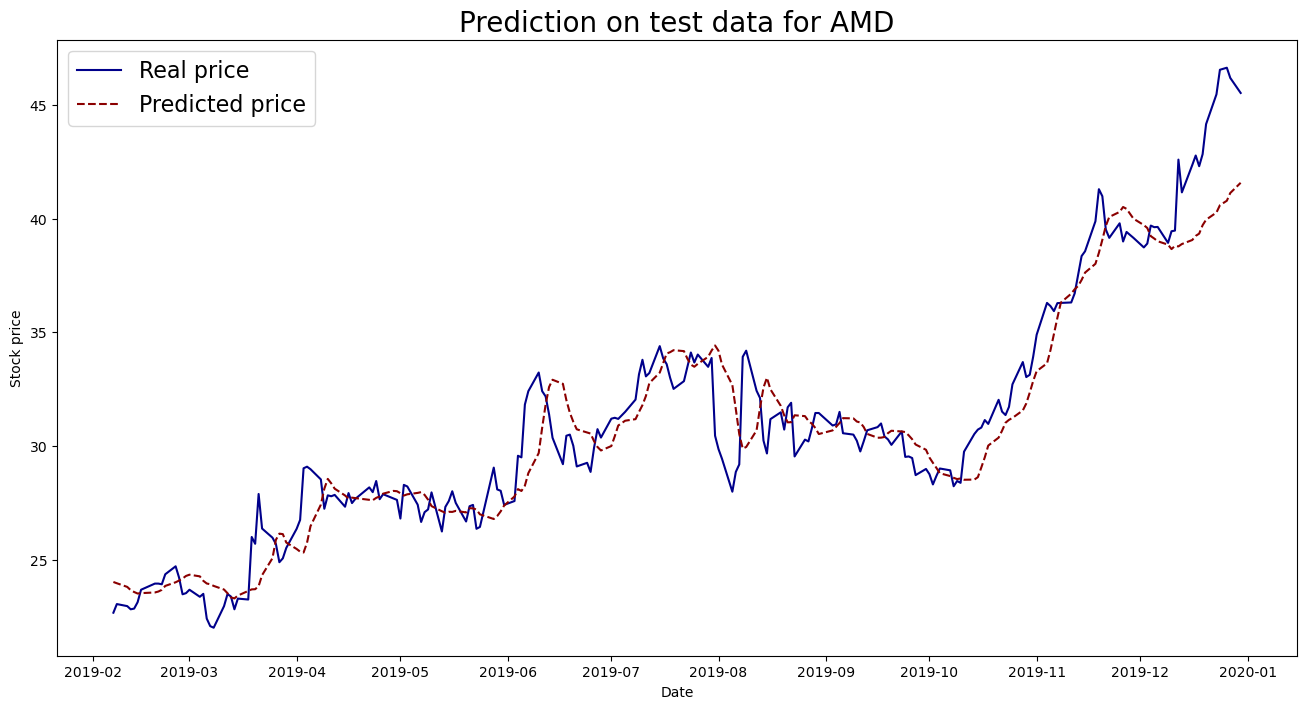

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from pickle import load
import numpy as np
from sklearn.metrics import mean_squared_error
from data_preprocess import output_dim

def plot_test_data(Real_test_price, Predicted_test_price, index_test):
    X_scaler = load(open('X_scaler.pkl', 'rb'))
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = index_test

    rescaled_Real_price = y_scaler.inverse_transform(Real_test_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_test_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=test_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)
  
    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=test_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)
  
    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)
    # 將預測價格寫入 CSV 文件
    predict_result['predicted_mean'].to_csv('predicted_prices.csv')
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis = 1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('Test RMSE: ', RMSE)
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"], color='#00008B')
    plt.plot(predict_result["predicted_mean"], color = '#8B0000', linestyle='--')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title(f"Prediction on test data for AMD", fontsize=20)
    plt.show()

batch_size = 5
predict_period = 1
index = dataset.iloc[batch_size:batch_size + len(y_batched), :].index
AMD_generator = tf.keras.models.load_model(f'AMD_generator_V_{499}.keras')
predicted_data = eval_op(AMD_generator,X_batched)
plot_test_data(y_batched, predicted_data,index)